# Detección de fallas en sensores IoT mediante Machine Learning

El objetivo del presente trabajo es utilizar técnicas de Aprendizaje Automático (Machine Learning) para detectar fallas en sensores IoT. Para ello, utilizaremos 2 datasets obtenidos de la página Kaggle, uno de ellos referidos a la [detección de incendios](https://www.kaggle.com/datasets/deepcontractor/smoke-detection-dataset) y otro refereido a la [detección de ocupantes en una habitación](https://www.kaggle.com/datasets/kukuroo3/room-occupancy-detection-data-iot-sensor).

## Plan de trabajo: Introducción de Ruido

El siguiente procedimiento será igual para ambos datasets y se repetirá para cada sensor:
- Sean $N$ la cantidad de observaciones de entrenamiento, $M$ la cantidad de observaciones de validación cruzada y $T$ la cantidad de observaciones de test.
- Se calculará $\hat{\sigma}$ el estimador del desvio estandar de los datos de entrenamiento.
-  Se realizarán los siguientes pasos para distintos valores de un coeficiente positivo $\alpha$.
-  Se generarán $2*N$ datos como ejemplos de observaciones con el sensor fallado. Estos ejemplos consistirán en la observación original $\pm \alpha * \hat{\sigma}$.
-  Se entrenará el modelo para detectar las observaciones manipuladas de las observaciones originales.
-  Se evaluará el modelo para distintos valores de $\beta$ que indicán la magnitud de los errores introducidos.
-  Para los datos de validación, se tomarán los datos de validación cruzada y nuevamente se generarán $2*M$ datos como ejemplos de observaciones con el sensor fallado. Estos ejemplos consistirán en la observación original $\pm \beta * \hat{\sigma}$.
-  Se evaluará la capacidad del modelo de detectar los fallidos vs los originales.

Se espera que al aumentar $\beta$ sea más fácil para el modelo detectar los casos anomalos. 

## Lectura y limpieza de los datasets

### Lectura y división en entrenamiento, validación y test

In [7]:
import pandas as pd
import numpy as np
humo = pd.read_csv('smoke_detection_iot.csv')

humo = humo.dropna().drop(columns=[humo.columns[0], "UTC","Fire Alarm", "CNT"])

ocupacion = pd.read_csv('occupancy.csv')
ocupacion = ocupacion.dropna().drop(columns=["date","Occupancy"])

In [8]:
humo_train, humo_cv, humo_test = np.split(humo.sample(frac=1), [int(.6*len(humo)), int(.8*len(humo))])
ocupacion_train, ocupacion_cv, ocupacion_test = np.split(ocupacion.sample(frac=1), [int(.6*len(ocupacion)), int(.8*len(ocupacion))])

## Definición de los modelos

Para comparar los modelos se crearan clases que envuelvan el modelo y permitan entrenarlo y evaluarlo de forma sencilla.

### Regresión Logística Simple

In [9]:
from sklearn.linear_model import LogisticRegression
class ModeloRegresionLogisticaScikit:
    @staticmethod
    def nombre():
        return "Regresion Logistica"

    def __init__(self, datos_originales):
        self.modelo = LogisticRegression(max_iter=1000)

    def entrenar(self, Xs, ys):
        self.modelo.fit(Xs,ys)

    def predecir(self, Xs):
        return self.modelo.predict(Xs)

### Modelo estadistico de detección de anomalias

Este es un modelo estadistico sencillo.
Consiste en simplemente calcular la probabilidad de que la observación sea generada por la distribución de los datos sin fallas, para lo cuál se la considerará como una normal multivariada. Se fijara el humbral que maximice la precisión en los datos de entrenamiento.

Formalmente:

$$
X \sim N(\mu, \Sigma)        (1)
$$

Donde $\mu$ y $\Sigma$ son los estimadores de la media y la matriz de covarianza de los datos de entrenamiento.

Se pueden acceder facilmente a $\mu$ y $\Sigma$ con *df.mean()* y *df.cov()* respectivamente.

In [10]:
from scipy.stats import multivariate_normal
class ModeloNormalMultivariada:
    
    @staticmethod
    def nombre():
        return "Normal Multivariada"

    def __init__(self, datos_originales):
        self.normal = multivariate_normal(mean=datos_originales.mean().values, cov=datos_originales.cov().values, allow_singular=True)
        
    def entrenar(self, Xs, ys):
        probs = self.normal.pdf(Xs)
        observaciones = list(zip(probs,ys))
        observaciones.sort(key=lambda x: x[0])
        umbral = 0
        pres = 1/3
        optimo = 1/3
        N = len(observaciones)
        for i, (prob, y) in enumerate(observaciones):
            if y == 1:
                pres += 1/N
            else:
                pres -= 1/N
            if pres>optimo:
                optimo = pres
                umbral = prob
        self.umbral = umbral
        self.optimo = optimo
        
    def predecir(self, Xs):
        return self.normal.pdf(Xs) < self.umbral


## Modelo de Bosque Aleatorio (Random Forest)

In [11]:
from sklearn.ensemble import RandomForestClassifier
class ModeloRandomForestScikit:
    @staticmethod
    def nombre():
        return "Random Forest"

    def __init__(self, datos_originales):
        self.modelo = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=0)
        
    def entrenar(self, Xs, ys):
        self.modelo.fit(Xs, ys)
        
    def predecir(self, Xs):
        return self.modelo.predict(Xs)

## Definición de la función de evaluación

Lo siguiente que corresponde es definir la función que utilizaremos para evaluar los modelos definidos en la sección anterior. La función deberá recibir el dataset, la columna a modificar, el modelo a evaluar y las grillas de $\alpha$ y $\beta$ . La función devolvera un diccionario donde la clave será el valor de $\alpha$ utilizado para el entrenamiento y el contenido será un dataframe con los resultados de evaluación para cada valor de $\beta$.

In [12]:
def Generar(Xs, columna, delta):
    Xs_suma = Xs.copy()
    Xs_suma[columna] += delta
    Xs_resta = Xs.copy()
    Xs_resta[columna] -= delta
    ys = np.array([0]*len(Xs) + [1]*2*len(Xs))
    return pd.concat([Xs, Xs_suma, Xs_resta], ignore_index=True), ys

def Evaluar(Xs_train, Xs_cv, columna, Modelo, alfas, betas):
    resultados = dict()
    for alfa in alfas:
        modelo = Modelo(Xs_train)
        desvio = np.std(Xs_train[columna])
        Xs_train_alfa, ys_train_alfa = Generar(Xs_train, columna, desvio*alfa)
        modelo.entrenar(Xs_train_alfa, ys_train_alfa)
        resultados_alfa = list()
        for beta in betas:
            Xs_cv_beta, ys_cv_beta = Generar(Xs_cv, columna, desvio*beta)
            preds = modelo.predecir(Xs_cv_beta)
            resultados_alfa.append(np.mean(preds == ys_cv_beta))
        resultados[alfa] = np.array(resultados_alfa)
    return resultados


In [13]:
from tqdm.notebook import tqdm
from time import time
def Evaluacion_Global(Xs_train, Xs_cv, Modelos, alfas, betas):
    Resultados = list()
    avance = tqdm(total=len(Modelos)*len(Xs_train.columns))
    for Modelo in Modelos:
        resultados_modelo = list()
        for columna in Xs_train.columns:
            t0 = time()
            resultados = Evaluar(Xs_train, Xs_cv, columna, Modelo, alfas, betas)
            t1 = time()
            print(f"Modelo {Modelo.nombre()} con {columna} en {t1-t0:.2f} segundos")
            resultados_modelo.append((resultados, t1-t0))
            avance.update(1)
        Resultados.append(resultados_modelo)
    return Resultados

## Generación de Resultados

In [14]:
Modelos = [
    #ModeloRegresionLogistica,
    ModeloRegresionLogisticaScikit,
    ModeloNormalMultivariada,
    ModeloRandomForestScikit
]
alfas = np.linspace(0, 6, 11)[1:]
betas = np.linspace(0, 6, 31)[1:]

In [15]:
Resultados_Ocupacion = Evaluacion_Global(ocupacion_train, ocupacion_cv, Modelos, alfas, betas)

  0%|          | 0/15 [00:00<?, ?it/s]

Modelo Regresion Logistica con Temperature en 16.24 segundos
Modelo Regresion Logistica con Humidity en 14.64 segundos
Modelo Regresion Logistica con Light en 13.77 segundos
Modelo Regresion Logistica con CO2 en 15.18 segundos
Modelo Regresion Logistica con HumidityRatio en 17.86 segundos
Modelo Normal Multivariada con Temperature en 5.76 segundos
Modelo Normal Multivariada con Humidity en 5.12 segundos
Modelo Normal Multivariada con Light en 5.33 segundos
Modelo Normal Multivariada con CO2 en 4.56 segundos
Modelo Normal Multivariada con HumidityRatio en 4.20 segundos
Modelo Random Forest con Temperature en 21.73 segundos
Modelo Random Forest con Humidity en 20.59 segundos
Modelo Random Forest con Light en 19.96 segundos
Modelo Random Forest con CO2 en 21.22 segundos
Modelo Random Forest con HumidityRatio en 20.29 segundos


In [16]:
Resultados_Ocupacion

[[({0.6: array([0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
           0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
           0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
           0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
           0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
           0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667]),
    1.2: array([0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
           0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
           0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
           0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
           0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
           0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667]),
    1.7999999999999998: array([0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
           0.66666667, 0.66666667, 0.666666

In [17]:
Resultados_Ocupacion

[[({0.6: array([0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
           0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
           0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
           0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
           0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
           0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667]),
    1.2: array([0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
           0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
           0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
           0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
           0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
           0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667]),
    1.7999999999999998: array([0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
           0.66666667, 0.66666667, 0.666666

In [18]:
Resultados_Humo = Evaluacion_Global(humo_train, humo_cv, Modelos, alfas, betas)

  0%|          | 0/36 [00:00<?, ?it/s]

Modelo Regresion Logistica con Temperature[C] en 44.35 segundos
Modelo Regresion Logistica con Humidity[%] en 45.54 segundos
Modelo Regresion Logistica con TVOC[ppb] en 73.65 segundos
Modelo Regresion Logistica con eCO2[ppm] en 45.45 segundos
Modelo Regresion Logistica con Raw H2 en 43.87 segundos
Modelo Regresion Logistica con Raw Ethanol en 41.36 segundos
Modelo Regresion Logistica con Pressure[hPa] en 46.60 segundos
Modelo Regresion Logistica con PM1.0 en 62.31 segundos
Modelo Regresion Logistica con PM2.5 en 93.39 segundos
Modelo Regresion Logistica con NC0.5 en 131.69 segundos
Modelo Regresion Logistica con NC1.0 en 94.74 segundos
Modelo Regresion Logistica con NC2.5 en 92.92 segundos
Modelo Normal Multivariada con Temperature[C] en 12.44 segundos
Modelo Normal Multivariada con Humidity[%] en 11.10 segundos
Modelo Normal Multivariada con TVOC[ppb] en 11.37 segundos
Modelo Normal Multivariada con eCO2[ppm] en 11.45 segundos
Modelo Normal Multivariada con Raw H2 en 11.38 segundos
Mo

## Representación gráfica de los resultados

In [19]:
import matplotlib.pyplot as plt
def Graficar(Nombre, Resultados, Modelos, Xs_train, alfas, betas, colores):
    n_columnas = len(Xs_train.columns)
    n_modelos = len(Resultados)
    fig, axs = plt.subplots(n_columnas, n_modelos, figsize=(n_modelos * 7, n_columnas * 3.5),constrained_layout=True)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)
    fig.suptitle(Nombre, fontsize=24)
    if n_modelos == 1 and n_columnas == 1:
        axs = np.array([[axs]])  # Hacer que axs sea 2D
    elif n_modelos == 1:
        axs = np.expand_dims(axs, axis=-1)  # Convertir a un array 2D con una única columna
    elif n_columnas == 1:
        axs = np.expand_dims(axs, axis=0) 
    
    for i, (modelo, resultados_modelo) in enumerate(zip(Modelos,Resultados)):
        for j, (resultados_columna, tiempo) in enumerate(resultados_modelo):
            ax = axs[j,i]
            for (alfa, resultados_alfa) in resultados_columna.items(): 
                ax.plot(betas, resultados_alfa, label=f"$\\alpha$={round(alfa,1)}",
                        color = (colores[i][0], colores[i][1], colores[i][2], 1-0.7*alfa/max(alfas)))
            ax.set_title(f"{Xs_train.columns[j]} | {modelo.nombre()} ({tiempo:.2f}s)", fontsize = 16)
            
    for ax in axs.flatten():
        ax.legend(ncol=2)
        ax.set_ylim(0,1)
        ax.set_xticks(betas, minor=True)
        ax.set_xticks([0] + list(filter(lambda x : round(x)==x, betas)))
        ax.grid(which="major", color="gray", linestyle="-", linewidth=1)
        ax.grid(which="minor", color="gray", linestyle=(0, (5, 10)), linewidth=0.5)
        ax.set_xlabel("$\\beta$")
        ax.set_ylabel("Accuracy")
            
    #plt.legend()
    plt.show()
    return (fig,axs)

/tmp/ipykernel_486964/1953187036.py:6: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)


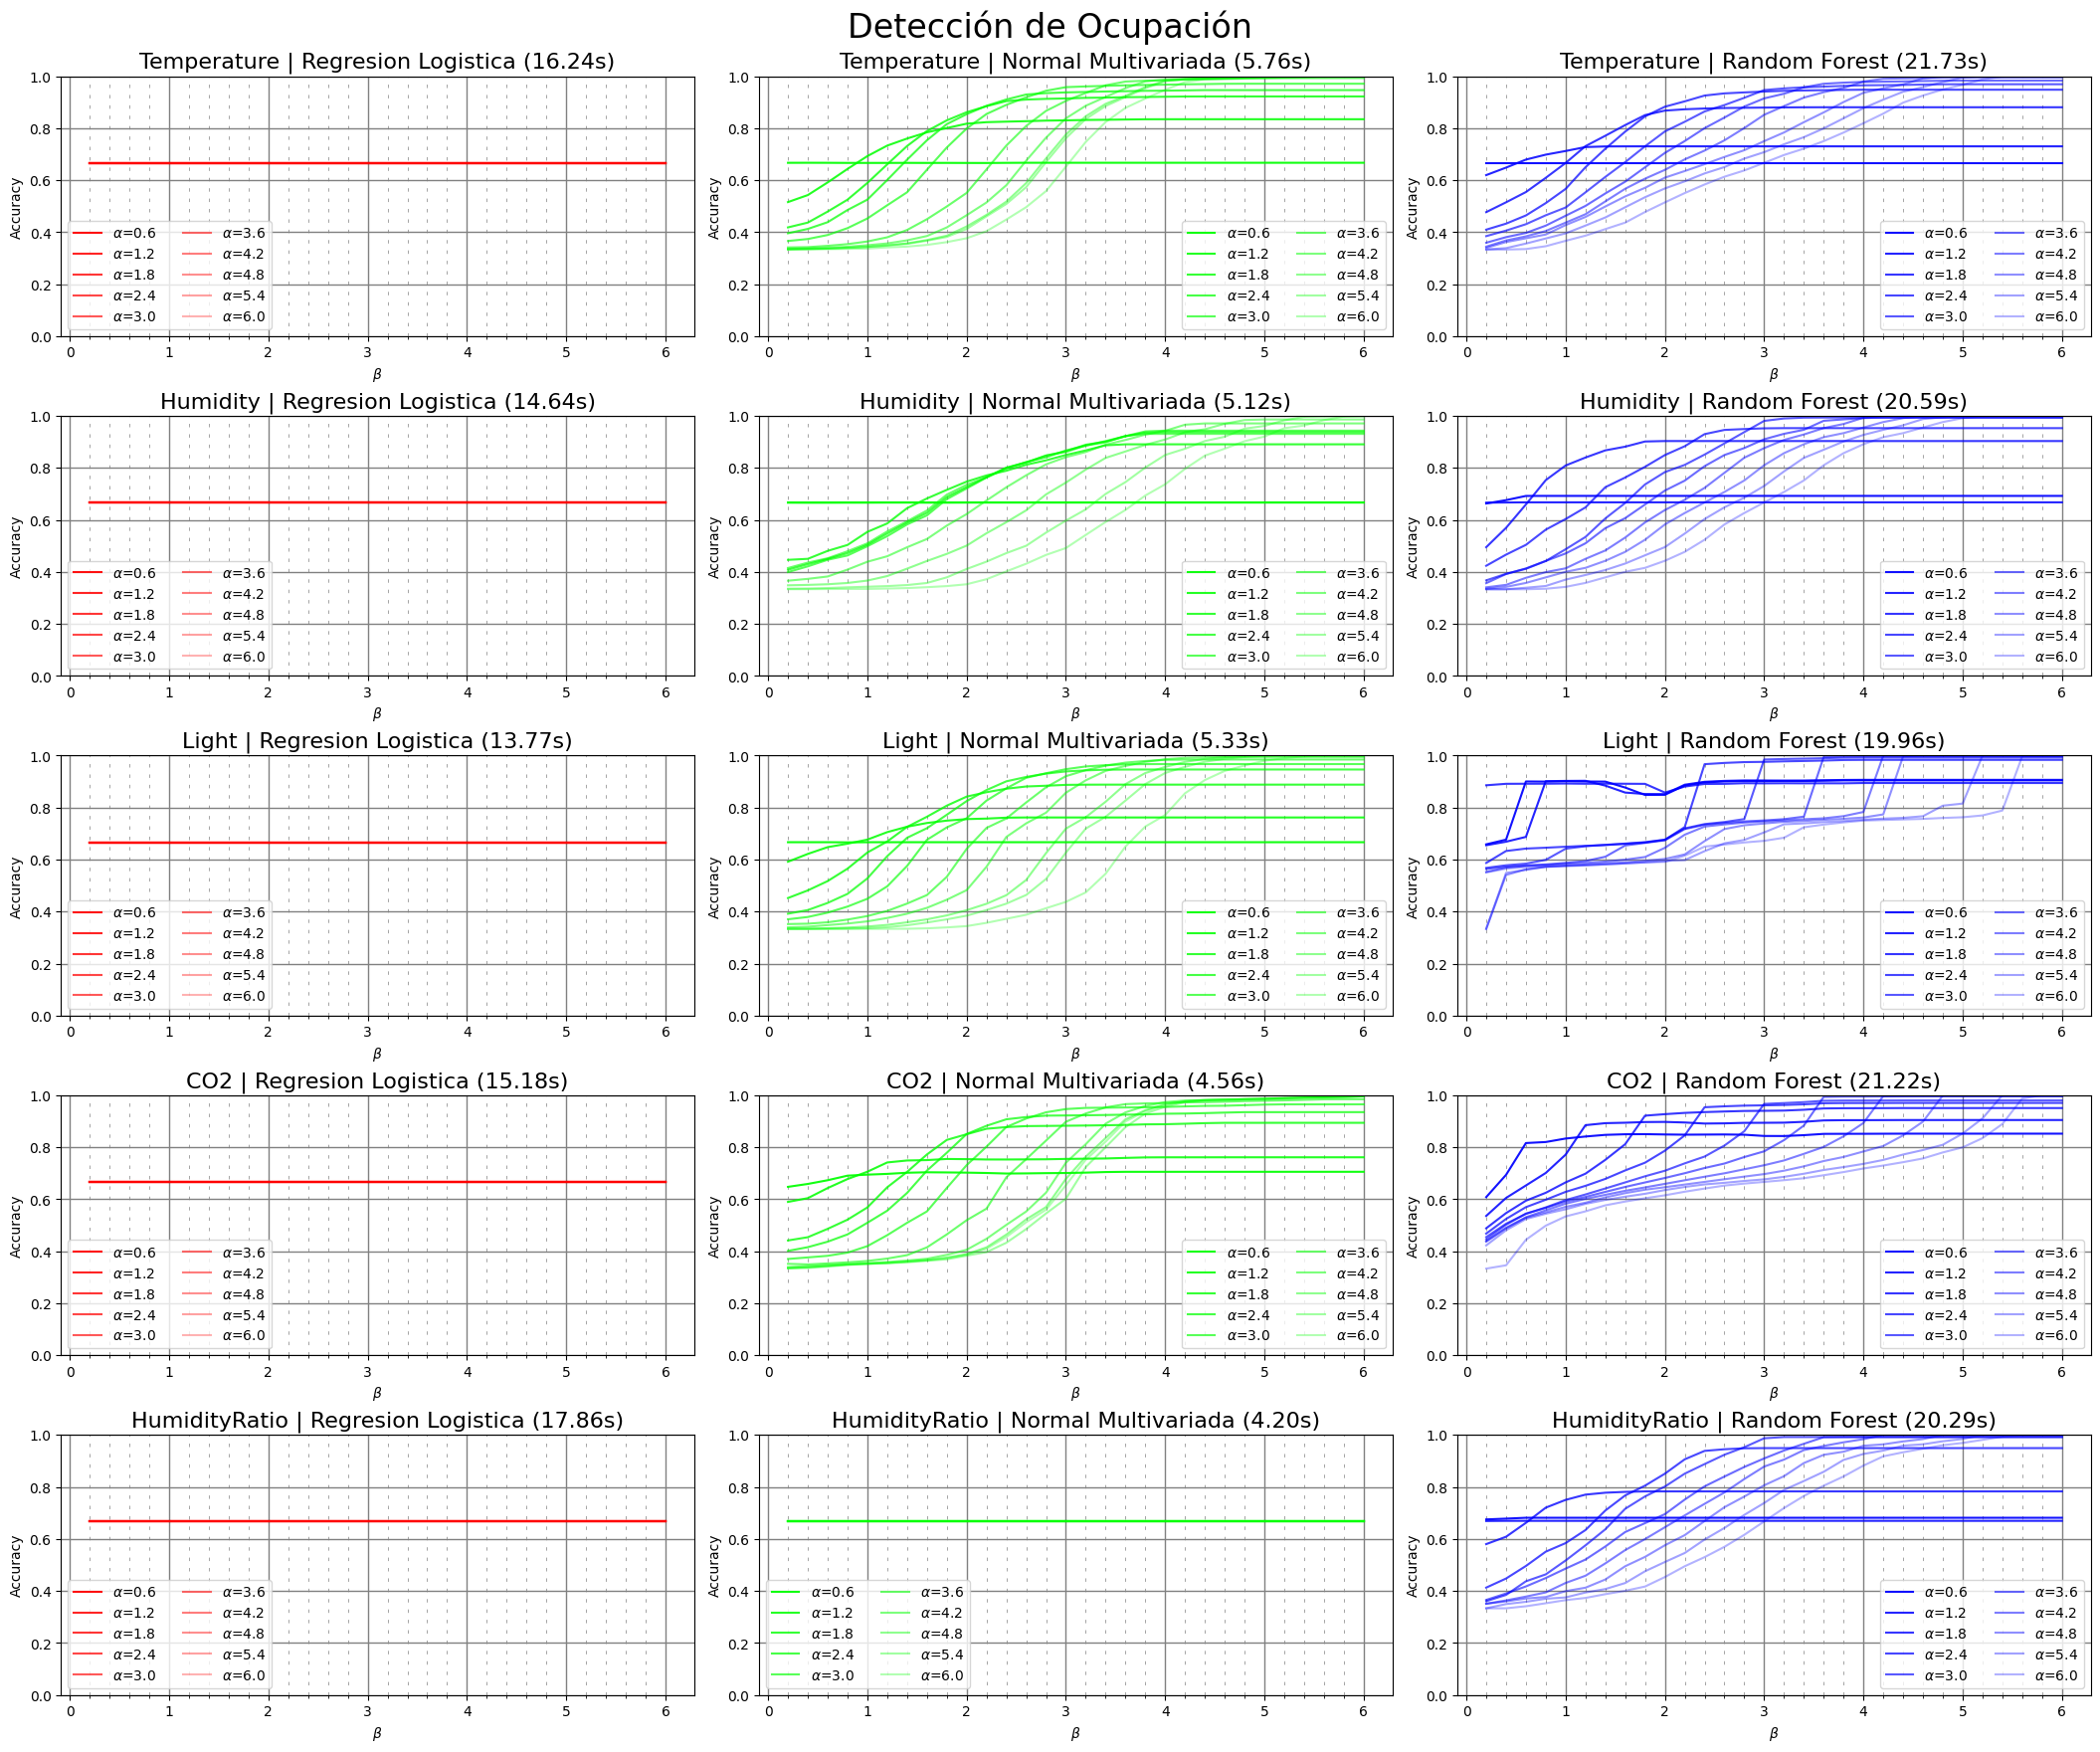

(<Figure size 2100x1750 with 15 Axes>,
 array([[<Axes: title={'center': 'Temperature | Regresion Logistica (16.24s)'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Temperature | Normal Multivariada (5.76s)'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Temperature | Random Forest (21.73s)'}, xlabel='$\\beta$', ylabel='Accuracy'>],
        [<Axes: title={'center': 'Humidity | Regresion Logistica (14.64s)'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Humidity | Normal Multivariada (5.12s)'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Humidity | Random Forest (20.59s)'}, xlabel='$\\beta$', ylabel='Accuracy'>],
        [<Axes: title={'center': 'Light | Regresion Logistica (13.77s)'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Light | Normal Multivariada (5.33s)'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Light | R

In [20]:
Graficar("Detección de Ocupación", 
         Resultados_Ocupacion, Modelos, ocupacion_train, 
         alfas, betas, [(1,0,0), (0,1,0), (0,0,1)])

/tmp/ipykernel_486964/1953187036.py:6: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)


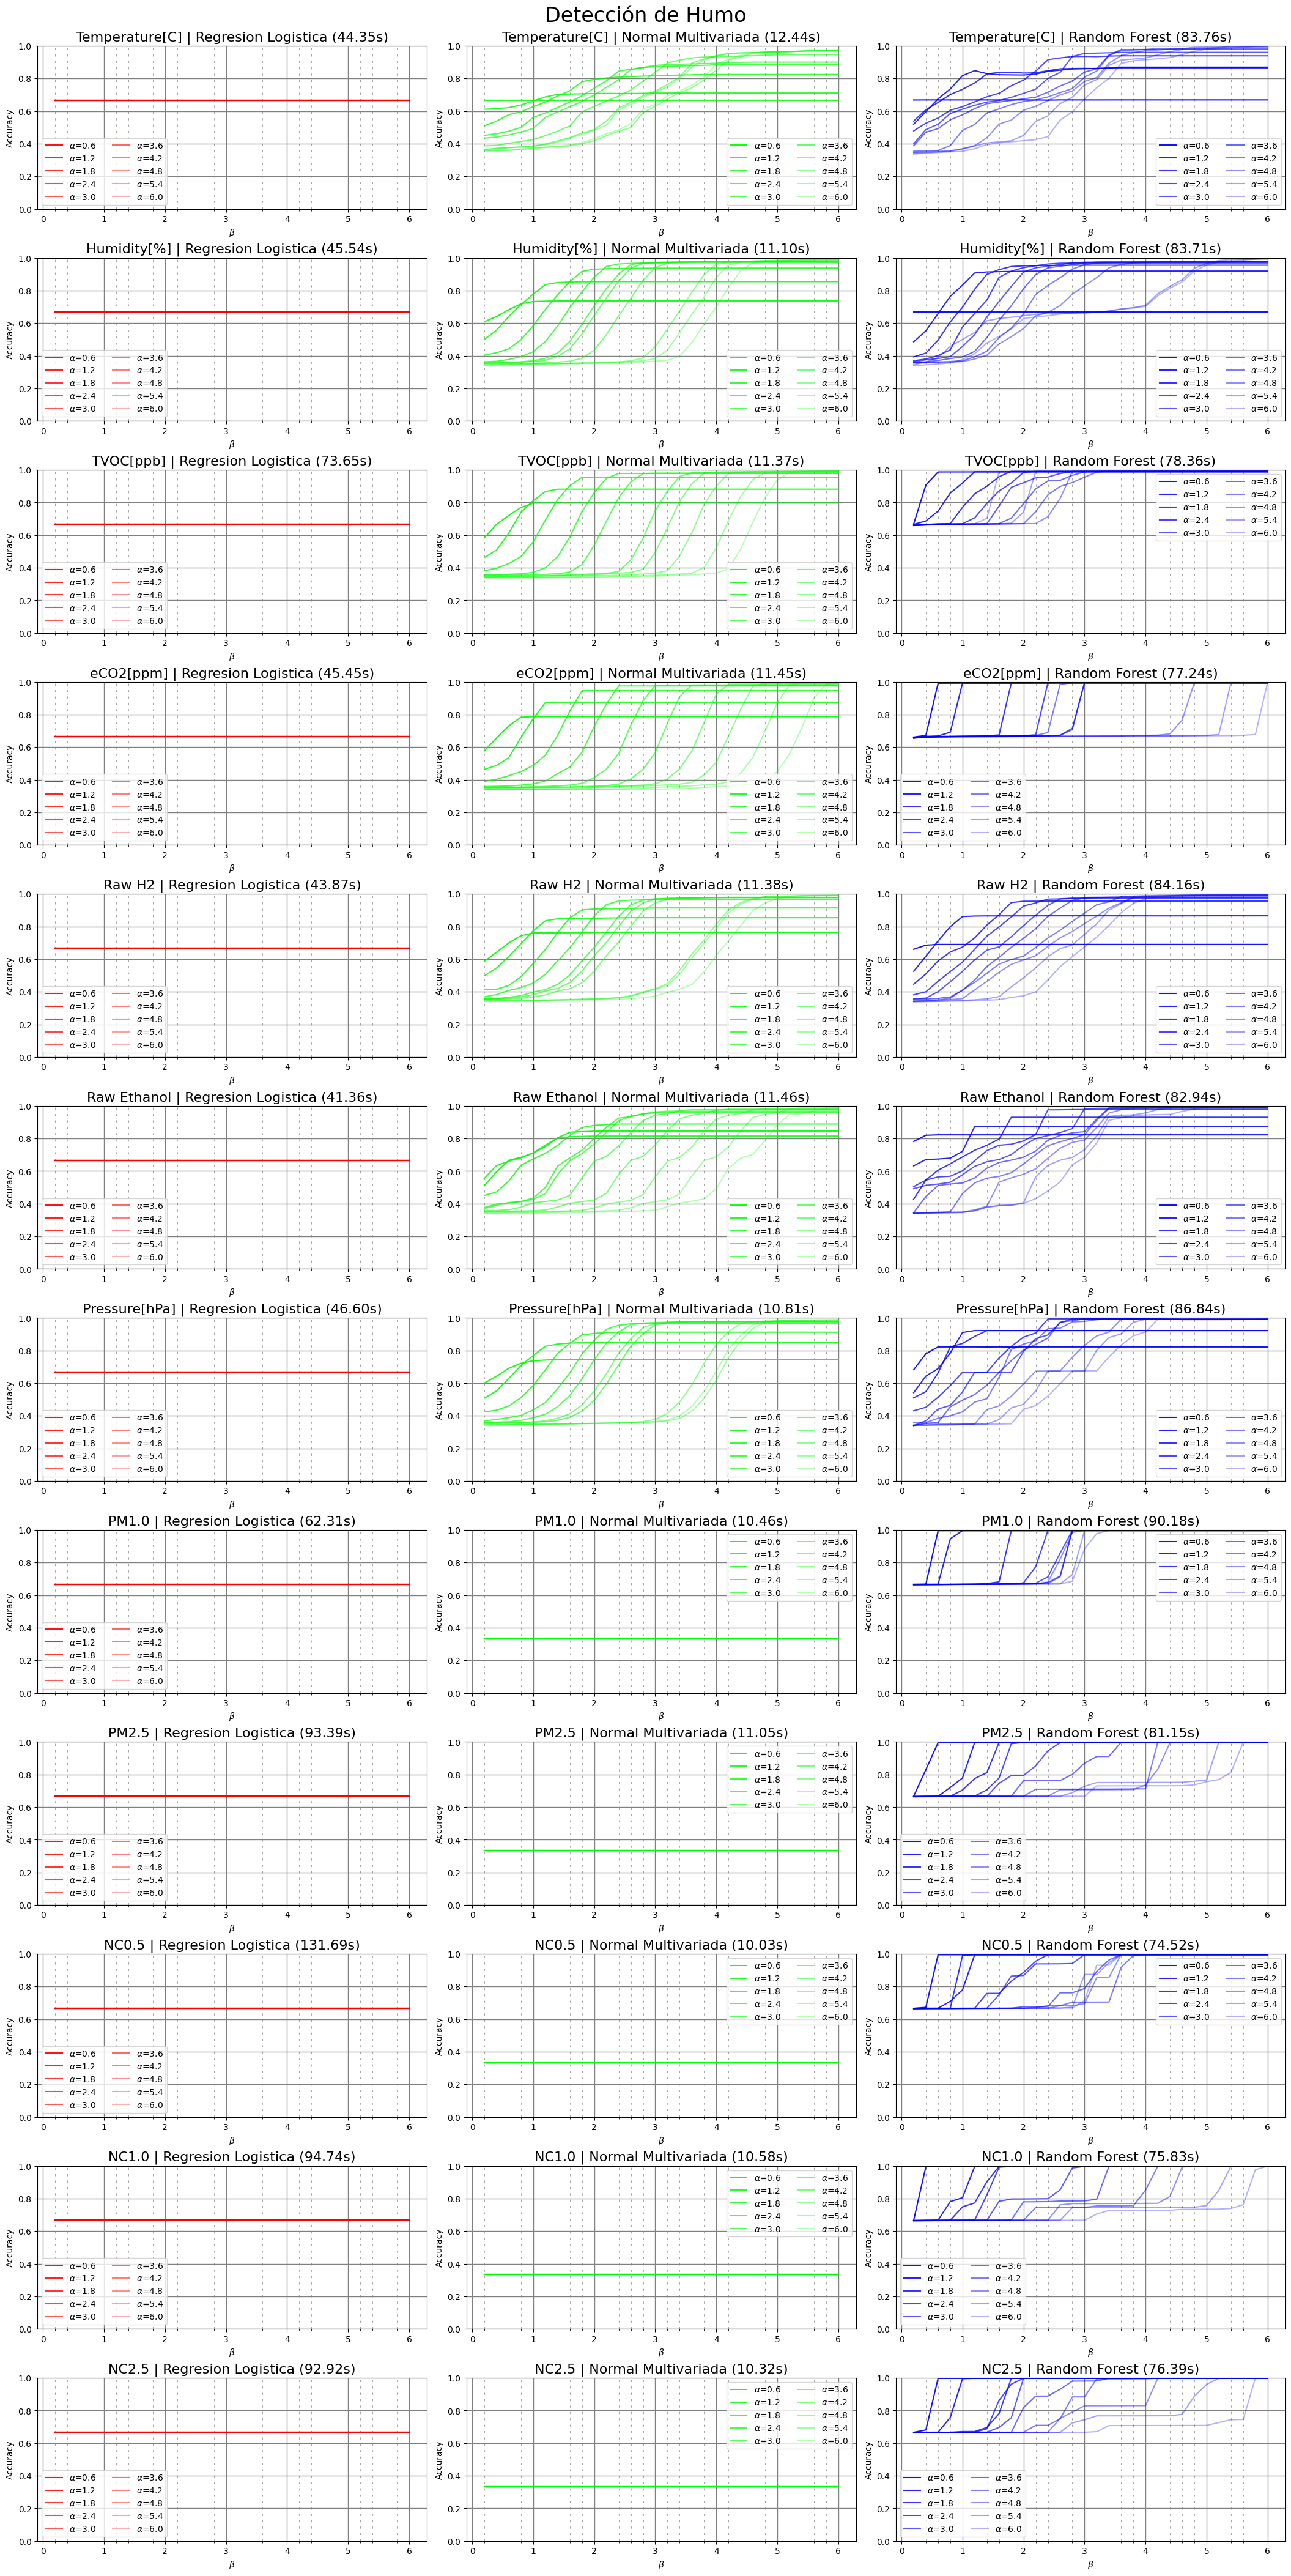

(<Figure size 2100x4200 with 36 Axes>,
 array([[<Axes: title={'center': 'Temperature[C] | Regresion Logistica (44.35s)'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Temperature[C] | Normal Multivariada (12.44s)'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Temperature[C] | Random Forest (83.76s)'}, xlabel='$\\beta$', ylabel='Accuracy'>],
        [<Axes: title={'center': 'Humidity[%] | Regresion Logistica (45.54s)'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Humidity[%] | Normal Multivariada (11.10s)'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Humidity[%] | Random Forest (83.71s)'}, xlabel='$\\beta$', ylabel='Accuracy'>],
        [<Axes: title={'center': 'TVOC[ppb] | Regresion Logistica (73.65s)'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'TVOC[ppb] | Normal Multivariada (11.37s)'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes

In [21]:
Graficar("Detección de Humo", 
         Resultados_Humo, Modelos, humo_train, 
         alfas, betas, [(1,0,0), (0,1,0), (0,0,1)])

# Detección de fallas con modelos multicategoricos

En las etapas anteriores se ha buscado detectar las fallas de cada sensor de forma individual haciendo foco en si ese sensor funciona correctamente o no. 

Otra posibilidad es entrenar un unico modelo que, sean $p$ los sensores, tenga $p+1$ categorias, una para cada sensor fallado y una para indicar que todos los sensores funcionan correctamente.



## Modelos

Convenientemente, los modelos antes definidos **Regresion Logistica Scikit Learn** y **Random Forest Scikit Learn** pueden ser utilizados para este caso ya que soporta multiples categorias de forma nativa.

Sin embargo, como hay que entrenar un modelo en vez de $p$ modelos, podemos permitirnos entrenar modelos más complejos, por lo cuál crearemos nuevas versiones de los modelos que tengan una mayor complejidad.

Aquí puede ser interesante ver dos cosas, por un lado la capacidad de detectar si algún sensor falla y por otro lado la capacidad de detectar cuál sensor falla.

### Regresión Logística Multinomial

In [22]:
class ModeloRegresionLogisticaMultinomial:
    @staticmethod
    def nombre():
        return "Regresion Logistica"
    
    def __init__(self, datos_originales):
        self.modelo = LogisticRegression(multi_class='multinomial', max_iter=1200)

    def entrenar(self, Xs, ys):
        self.modelo.fit(Xs,ys)
    
    def predecir(self, Xs):
        return self.modelo.predict(Xs)

### Normal Multivariada Multinomial

Para la Normal Multivariada lo que se hará es dividir la población de entrenamiento en las diferentes categorias y generar la normal multivariada para cada una de ellas.

Para clasificar se seleccionará aquella más verosimil, es decir aquella categoría que le asigne mayor probabilidad puntual a la observación.

In [23]:
class ModeloNormalMultivariadaMultinomial:
    @staticmethod
    def nombre():
        return "Normal Multivariada"
    
    def __init__(self, datos_originales):
        pass

    def entrenar(self, Xs, ys):
        self.n_class = len(np.unique(ys))
        self.classes = np.unique(ys)
        self.medias = Xs.groupby(ys).mean()
        self.covs = Xs.groupby(ys).cov()

        self.distribuciones = [
            multivariate_normal(mean=self.medias.loc[i].values, cov=self.covs.loc[i].values, allow_singular=True) for i in range(self.n_class)
        ]

    def predecir(self, Xs):
        probs = np.array([d.pdf(Xs) for d in self.distribuciones])
        return self.classes[np.argmax(probs, axis=0)]

### Random Forest Multinomial

In [24]:
class ModeloRandomForestMultinomial:
    @staticmethod
    def nombre():
        return "Random Forest"

    def __init__(self, datos_originales):
        self.modelo = RandomForestClassifier(n_estimators=400, max_depth=8, random_state=0)
        
    def entrenar(self, Xs, ys):
        self.modelo.fit(Xs, ys)
        
    def predecir(self, Xs):
        return self.modelo.predict(Xs)

### Gradient Boosting Multinomial

No utilizado debido a ser demasiado lento de entrenar.

In [25]:
from sklearn.ensemble import GradientBoostingClassifier

class ModeloGradientBoostingMultinomial:
    @staticmethod
    def nombre():
        return "Gradient Boosting"

    def __init__(self, datos_originales):
        self.modelo = GradientBoostingClassifier(n_estimators=400, max_depth=8, random_state=0)
        
    def entrenar(self, Xs, ys):
        self.modelo.fit(Xs, ys)
        
    def predecir(self, Xs):
        return self.modelo.predict(Xs)

## Evaluación

In [26]:
def Generar_Multicategoria(Xs, stds, alfa, ratio):
    array_X = [Xs]
    array_Y = [np.array([0]*len(Xs))]
    for i in range(ratio):
        Xs_i = Xs.copy()
        random = np.random.randint(0,len(Xs.columns),len(Xs))
        signo = np.random.choice([-1,1],len(Xs))
        Xs_i.iloc[:,random] += stds[random]*alfa*signo
        array_X.append(Xs_i)
        array_Y.append((random+1))
    return pd.concat(array_X, ignore_index=True), np.concatenate(array_Y)

def Evaluar_Multicategoria(Xs_train, Xs_cv, Modelo, alfas, betas, ratio = 1, tqdm_bar = None):
    resultados = dict()
    for alfa in alfas:
        modelo = Modelo(Xs_train)
        desvios = Xs_train.std()
        Xs_train_alfa, ys_train_alfa = Generar_Multicategoria(Xs_train, desvios, alfa, ratio)
        modelo.entrenar(Xs_train_alfa, ys_train_alfa)
        deteccion = list()
        atribucion = list()
        for beta in betas:
            Xs_cv_beta, ys_cv_beta = Generar_Multicategoria(Xs_cv, desvios, beta, len(Xs_train.columns))
            preds = modelo.predecir(Xs_cv_beta)
            deteccion.append(np.mean((preds==0) == (ys_cv_beta==0)))
            atribucion.append(np.mean(preds == ys_cv_beta))
        resultados[alfa] = np.array((deteccion,atribucion))
        if tqdm_bar is not None:
            tqdm_bar.update(1)
    return resultados

In [27]:
def Evaluacion_Global_Multicategoria(Xs_train, Xs_cv, Modelos, alfas, betas, ratio = 1):
    Resultados = list()
    avance = tqdm(total=len(Modelos) * len(alfas))
    for Modelo in Modelos:
        t0 = time()
        resultados = Evaluar_Multicategoria(Xs_train, Xs_cv, Modelo, alfas, betas, ratio = ratio, tqdm_bar = avance)
        t1 = time()
        print(f"Modelo {Modelo.nombre()} en {t1-t0:.2f} segundos")
        Resultados.append((resultados,t1-t0))
    return Resultados

## Generar resultados

In [28]:
Modelos_MC = [
    ModeloRegresionLogisticaMultinomial,
    ModeloNormalMultivariadaMultinomial,
    ModeloRandomForestMultinomial,
]

alfas_mc = list(np.linspace(0,1,5)[1:-1])+list(np.linspace(0,6,7)[1:])
betas_mc = np.linspace(0,7,36)[1:]

In [29]:
Resultados_Ocupacion_MC = Evaluacion_Global_Multicategoria(ocupacion_train, ocupacion_cv, Modelos_MC, alfas_mc, betas_mc, ratio = len(ocupacion_train.columns)*2)

  0%|          | 0/27 [00:00<?, ?it/s]

TypeError: LogisticRegression.fit() got an unexpected keyword argument 'verbose'

In [ ]:
Resultados_Humo_MC = Evaluacion_Global_Multicategoria(humo_train, humo_cv, Modelos_MC, alfas_mc, betas_mc, ratio = len(humo_train.columns)*2)

  0%|          | 0/27 [00:00<?, ?it/s]

/home/lautaro/anaconda3/envs/data_11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


/home/lautaro/anaconda3/envs/data_11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lautaro/anaconda3/envs/data_11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/lautaro/anaconda3/envs/data_11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (s

Modelo Regresion Logistica en 7264.40 segundos
Modelo Normal Multivariada en 5074.56 segundos
Modelo Random Forest en 5941.95 segundos


## Graficar resultados

In [ ]:
def Graficar_Multicategoria(Nombre, Resultados, Modelos, Xs_train, alfas, betas, colores):
    n_columnas = len(Xs_train.columns)
    n_modelos = len(Resultados)
    fig, axs = plt.subplots(n_modelos, 2, figsize=(12,n_modelos * 3.5),constrained_layout=True)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)
    fig.suptitle(Nombre, fontsize=24)

    for i, (modelo, resultados_modelo) in enumerate(zip(Modelos,Resultados)):
        ax = axs[i,0]
        resultados, tiempo = resultados_modelo
        for (alfa, resultados_alfa) in resultados.items(): 
            deteccion, _ = resultados_alfa
            
            ax.plot(betas, deteccion, label=f"$\\alpha$={round(alfa,1)}",
                    color = (colores[i][0], colores[i][1], colores[i][2], 1-0.7*alfa/max(alfas)))
            ax.set_title(f"{modelo.nombre()} | Detección ({tiempo:.2f}s)", fontsize = 16)
            ax.set_xlabel("$\\beta$")
            ax.set_ylabel("Accuracy")
        p_random = 1/((len(Xs_train.columns)+1)**2) + (len(Xs_train.columns)/((len(Xs_train.columns)+1)))**2
        ax.axhline(
            y=p_random, color="black", linestyle="--", label="Random"
        )
        
        ax = axs[i,1]
        for (alfa, resultados_alfa) in resultados.items(): 
            _, atribucion = resultados_alfa
            ax.plot(betas, atribucion, label=f"$\\alpha$={round(alfa,1)}",
                    color = (colores[i][0], colores[i][1], colores[i][2], 1-0.7*alfa/max(alfas)))
            ax.set_title(f"{modelo.nombre()} | Atribución ({tiempo:.2f}s)", fontsize = 16)
            ax.set_xlabel("$\\beta$")
            ax.set_ylabel("Accuracy")
        
        ax.axhline(
            y=1/(len(Xs_train.columns)+1), color="black", linestyle="--", label="Random"
        )

    for ax in axs.flatten():
        ax.legend(ncol=2)
        
        ax.set_ylim(0,1)
        ax.set_xticks(betas, minor=True)
        ax.set_xticks([0] + list(filter(lambda x : round(x)==x, betas)))
        ax.grid(which="major", color="gray", linestyle="-", linewidth=1)
        ax.grid(which="minor", color="gray", linestyle=(0, (5, 10)), linewidth=0.5)
    #plt.legend()
    plt.show()
    return (fig,axs)

In [ ]:
def Graficar_Multicategoria_Alfa(Nombre, Resultados, Modelos, Xs_train, alfas, betas, colores):
    fig, axs = plt.subplots(len(alfas), 2, figsize=(12,len(alfas) * 3.5),constrained_layout=True)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)
    fig.suptitle(Nombre, fontsize=24)
    
    for i, (modelo, resultados_modelo) in enumerate(zip(Modelos,Resultados)):
        resultados, tiempo = resultados_modelo
        for (alfa, resultados_alfa) in resultados.items(): 
            i_alfa = np.where(alfas == alfa)[0][0]
            ax = axs[i_alfa,0]
            deteccion, _ = resultados_alfa
            ax.plot(betas, deteccion, label=f"{modelo.nombre()}",
                    color = (colores[i][0], colores[i][1], colores[i][2], 1))
        
        for (alfa, resultados_alfa) in resultados.items(): 
            i_alfa = np.where(alfas == alfa)[0][0]
            ax = axs[i_alfa,1]
            _, atribucion = resultados_alfa
            ax.plot(betas, atribucion, label=f"{modelo.nombre()}",
                    color = (colores[i][0], colores[i][1], colores[i][2], 1))
           

    for i_alfa in range(len(alfas)):
        ax_d = axs[i_alfa,0]
        ax_a = axs[i_alfa,1]
        for (ax, titulo) in [(ax_d, "Deteccion"), (ax_a,"Atribución")]:
            ax.set_title(f"{titulo} con $\\alpha$ = {alfas[i_alfa]}", fontsize = 16)
            ax.set_xlabel("$\\beta$")
            ax.set_ylabel("Accuracy")
        
        p_random = 1/((len(Xs_train.columns)+1)**2) + (len(Xs_train.columns)/((len(Xs_train.columns)+1)))**2
        ax_d.axhline(
            y=p_random, color="black", linestyle="--", label="Random"
        )
        ax_a.axhline(
            y = 1/(len(Xs_train.columns)+1), color="black", linestyle="--", label="Random"
        )

    for ax in axs.flatten():
        ax.legend(ncol=2)
        ax.set_ylim(0,1)
        ax.set_xticks(betas, minor=True)
        ax.set_xticks([0] + list(filter(lambda x : round(x)==x, betas)))
        ax.grid(which="major", color="gray", linestyle="-", linewidth=1)
        ax.grid(which="minor", color="gray", linestyle=(0, (5, 10)), linewidth=0.5)
    #plt.legend()
    plt.show()
    return (fig,axs)

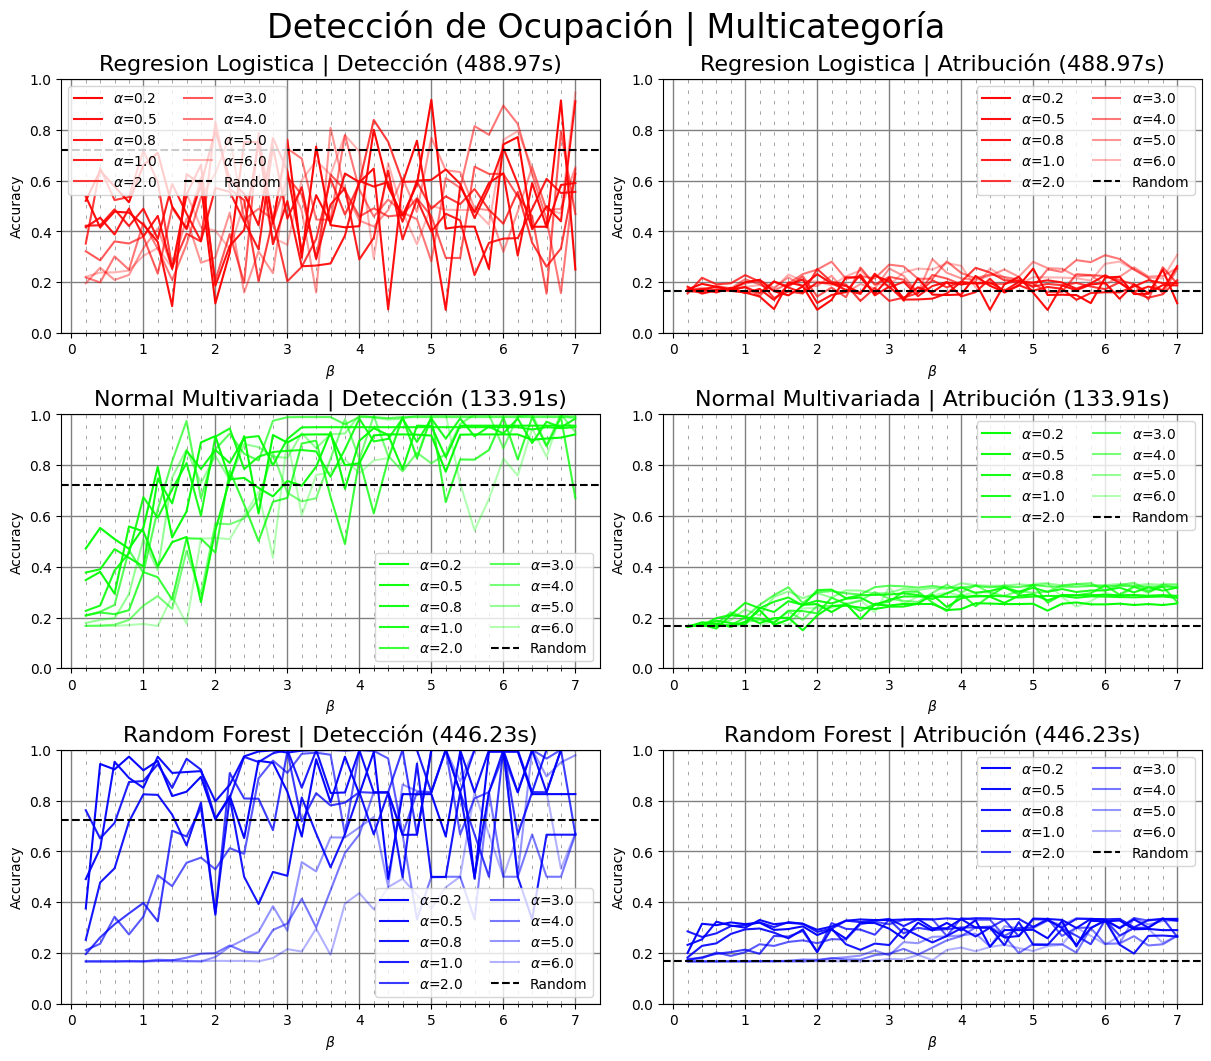

(<Figure size 1200x1050 with 6 Axes>,
 array([[<Axes: title={'center': 'Regresion Logistica | Detección (488.97s)'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Regresion Logistica | Atribución (488.97s)'}, xlabel='$\\beta$', ylabel='Accuracy'>],
        [<Axes: title={'center': 'Normal Multivariada | Detección (133.91s)'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Normal Multivariada | Atribución (133.91s)'}, xlabel='$\\beta$', ylabel='Accuracy'>],
        [<Axes: title={'center': 'Random Forest | Detección (446.23s)'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Random Forest | Atribución (446.23s)'}, xlabel='$\\beta$', ylabel='Accuracy'>]],
       dtype=object))

In [ ]:
Graficar_Multicategoria("Detección de Ocupación | Multicategoría", 
         Resultados_Ocupacion_MC, Modelos_MC, ocupacion_train, 
         alfas_mc, betas_mc, [(1,0,0), (0,1,0),(0,0,1)])

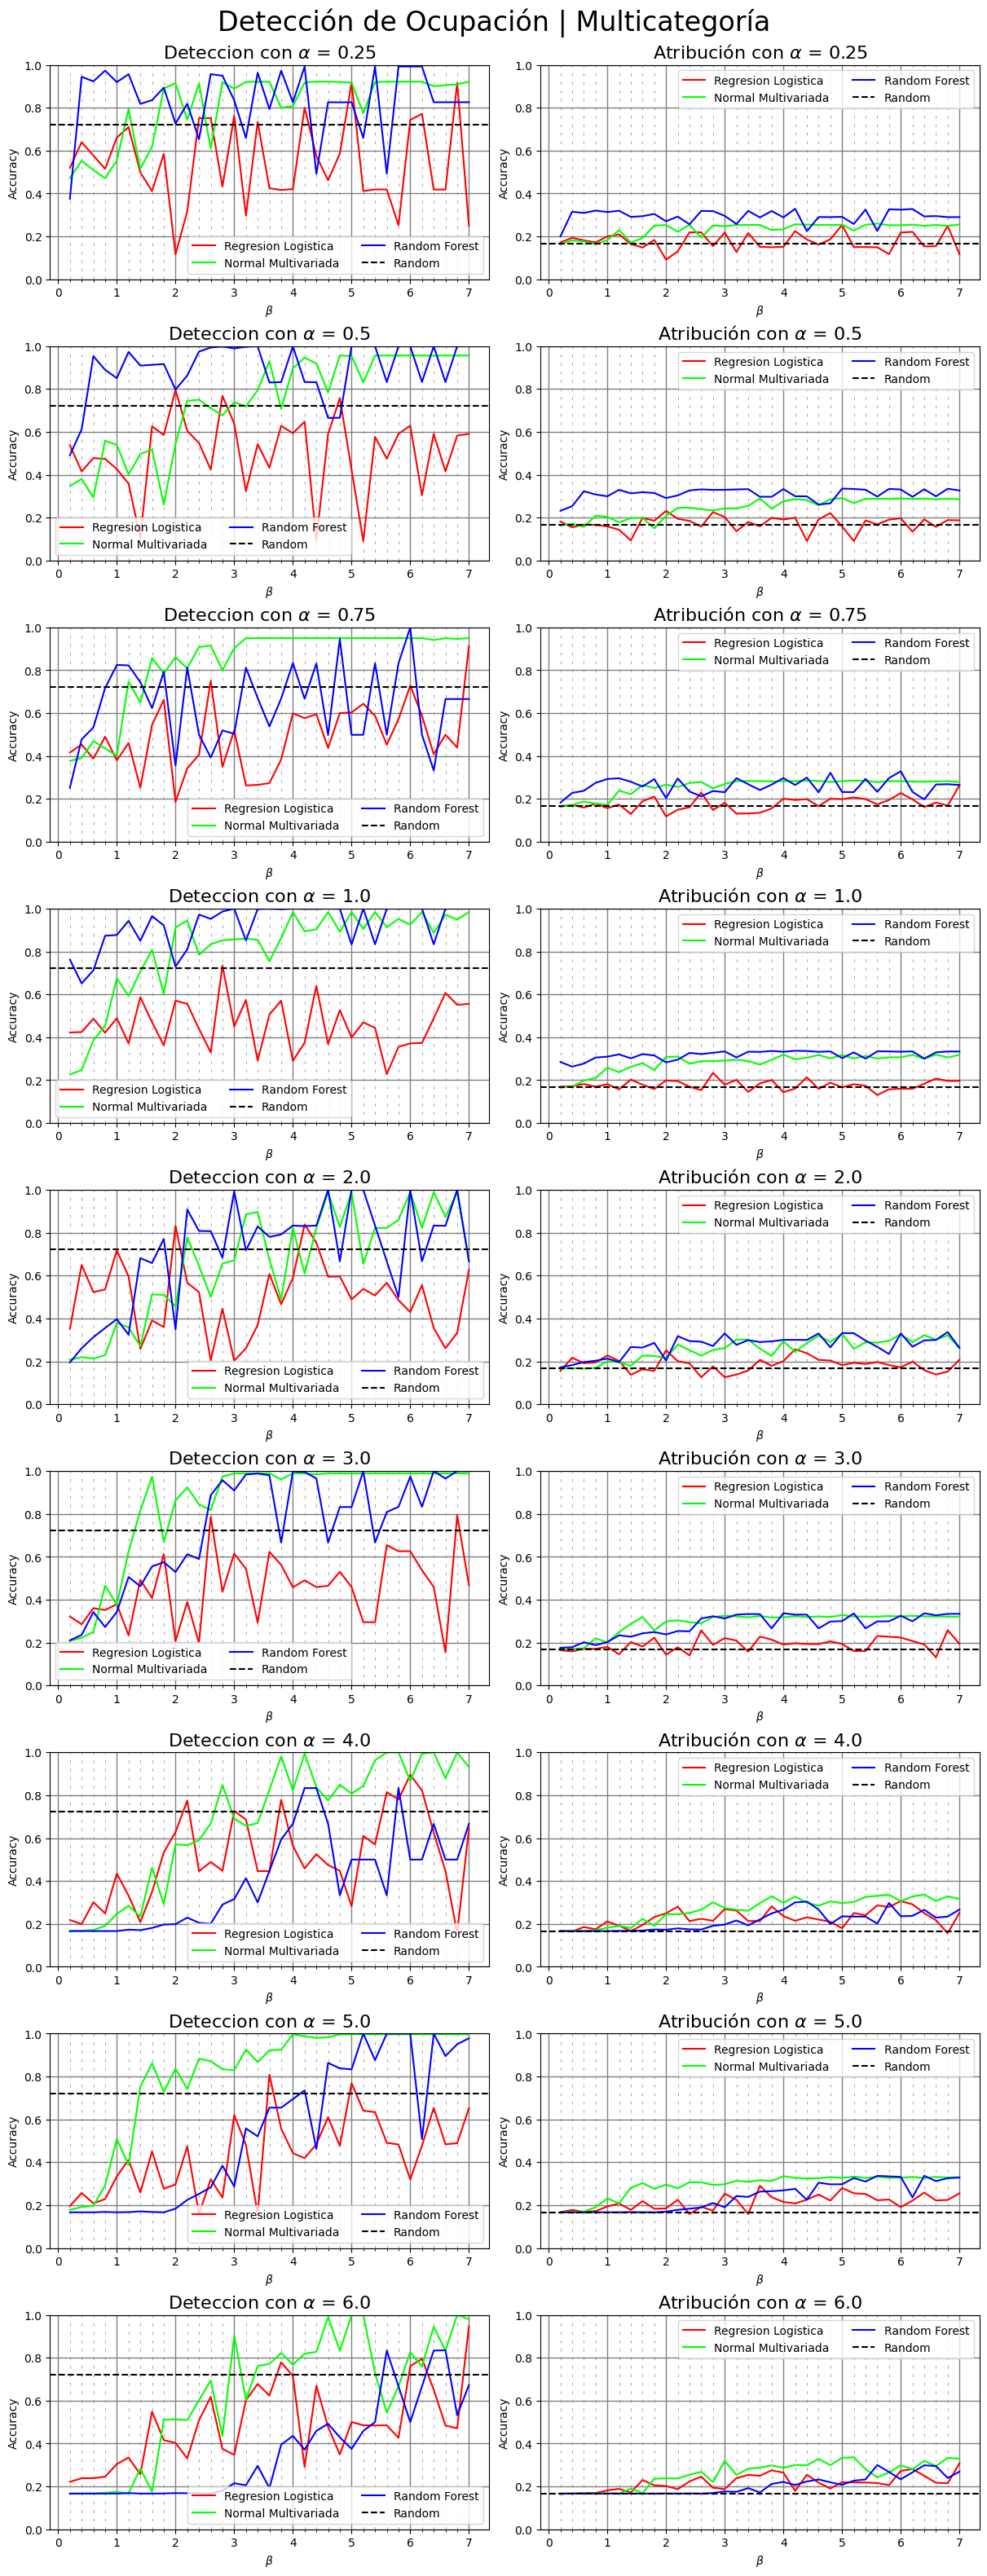

(<Figure size 1200x3150 with 18 Axes>,
 array([[<Axes: title={'center': 'Deteccion con $\\alpha$ = 0.25'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Atribución con $\\alpha$ = 0.25'}, xlabel='$\\beta$', ylabel='Accuracy'>],
        [<Axes: title={'center': 'Deteccion con $\\alpha$ = 0.5'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Atribución con $\\alpha$ = 0.5'}, xlabel='$\\beta$', ylabel='Accuracy'>],
        [<Axes: title={'center': 'Deteccion con $\\alpha$ = 0.75'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Atribución con $\\alpha$ = 0.75'}, xlabel='$\\beta$', ylabel='Accuracy'>],
        [<Axes: title={'center': 'Deteccion con $\\alpha$ = 1.0'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Atribución con $\\alpha$ = 1.0'}, xlabel='$\\beta$', ylabel='Accuracy'>],
        [<Axes: title={'center': 'Deteccion con $\\alpha$ = 2.0'}, xlabel='$\\beta$', ylabel='Accurac

In [ ]:
Graficar_Multicategoria_Alfa("Detección de Ocupación | Multicategoría",Resultados_Ocupacion_MC, Modelos_MC, ocupacion_train, alfas_mc, betas_mc, [(1,0,0), (0,1,0),(0,0,1)])

/tmp/ipykernel_118400/847342390.py:5: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)


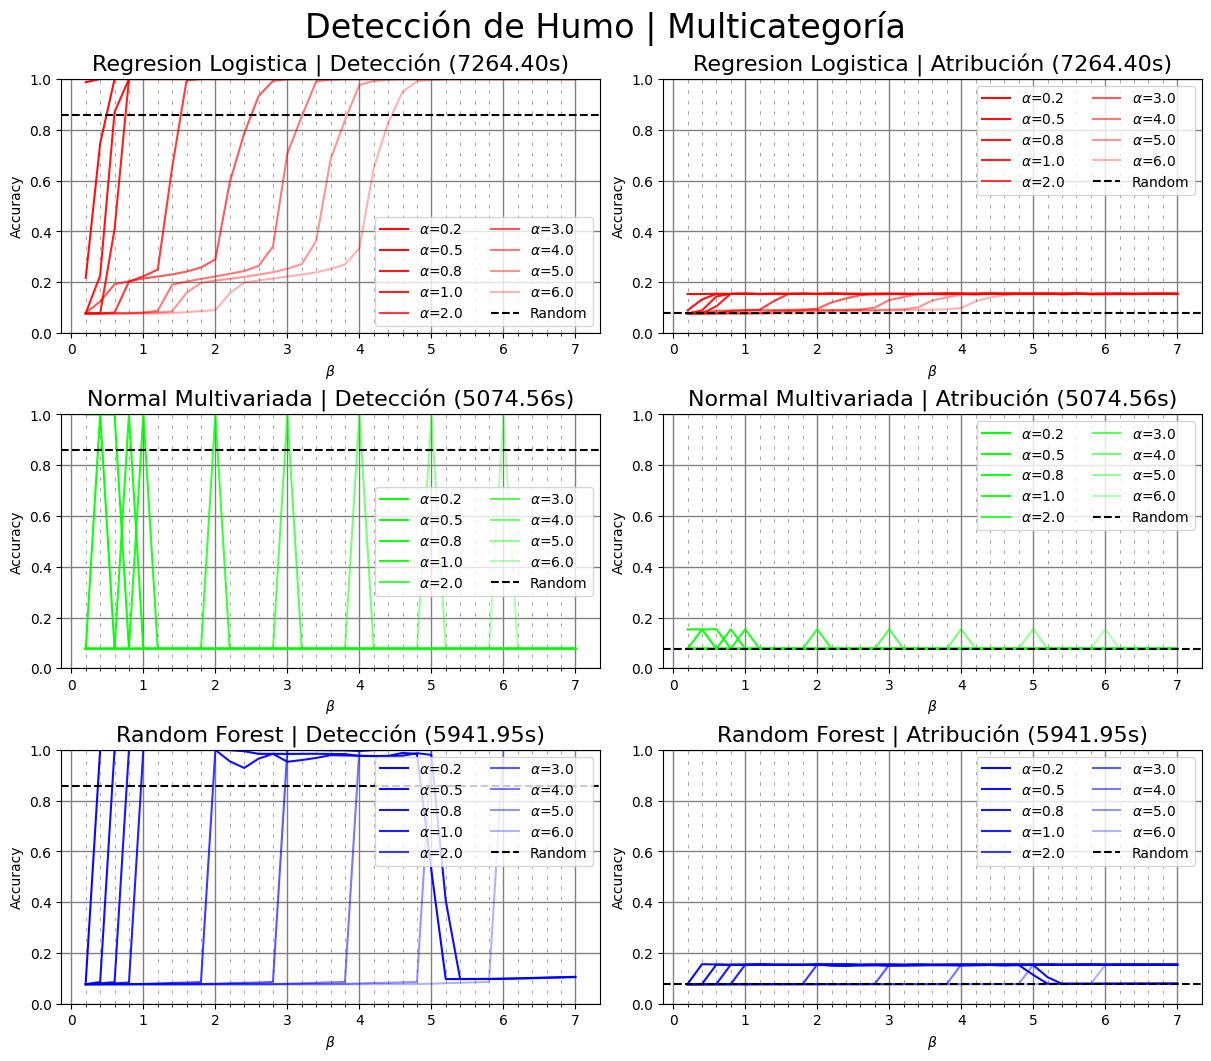

(<Figure size 1200x1050 with 6 Axes>,
 array([[<Axes: title={'center': 'Regresion Logistica | Detección (7264.40s)'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Regresion Logistica | Atribución (7264.40s)'}, xlabel='$\\beta$', ylabel='Accuracy'>],
        [<Axes: title={'center': 'Normal Multivariada | Detección (5074.56s)'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Normal Multivariada | Atribución (5074.56s)'}, xlabel='$\\beta$', ylabel='Accuracy'>],
        [<Axes: title={'center': 'Random Forest | Detección (5941.95s)'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Random Forest | Atribución (5941.95s)'}, xlabel='$\\beta$', ylabel='Accuracy'>]],
       dtype=object))

In [ ]:
Graficar_Multicategoria("Detección de Humo | Multicategoría", 
         Resultados_Humo_MC, Modelos_MC, humo_train, 
         alfas_mc, betas_mc, [(1,0,0), (0,1,0),(0,0,1)])

In [ ]:
Graficar_Multicategoria_Alfa("Detección de Humo | Multicategoría",Resultados_Humo_MC, Modelos_MC, humo_train, alfas_mc, betas_mc, [(1,0,0), (0,1,0),(0,0,1)])

NameError: name 'Graficar_Multicategoria_Alfa' is not defined